In [ ]:
# install GLiNER if not existed
%%capture
!pip install gliner

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import LongTensor, FloatTensor
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import pandas as pd
from tqdm import tqdm
import json
import random
from collections import Counter
from gliner import GLiNER
from matplotlib import pyplot as plt

In [ ]:
!wget 'https://raw.githubusercontent.com/SuperDim666/DistilledGliNER/main/model/data/data.json' -O data.json

--2024-04-30 20:18:54--  https://raw.githubusercontent.com/SuperDim666/DistilledGliNER/main/model/data/data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41986055 (40M) [text/plain]
Saving to: ‘data.json’

data.json           100%[===================>]  40.04M  --.-KB/s    in 0.1s    

2024-04-30 20:18:56 (375 MB/s) - ‘data.json’ saved [41986055/41986055]



In [ ]:
def read_json_dataset(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        data = json.load(file)
    sentences = []
    tags = []
    j = 0
    for entry in data:
        tokens = entry['tokenized_text']
        ner_tags = ['O'] * len(tokens)
        unavail_ner = False
        for ner in entry['ner']:
            start, end, label = ner
            if (not isinstance(label, str)):
                unavail_ner = True
                break
            for i in range(start, end + 1):
                if i == start:
                    # ner_tags[i] = 'B-' + label  # start lable: 'B-'
                    ner_tags[i] = label
                else:
                    # ner_tags[i] = 'I-' + label  # end lable 'I-'
                    ner_tags[i] = label  # end lable 'I-'

        if unavail_ner:
            continue
        # tokens.insert(0, '-START-')
        # tokens.append('-END-')
        # ner_tags.insert(0, '-START-')
        # ner_tags.append('-END-')
        sentences.append(tokens)
        tags.append(ner_tags)
    return sentences, tags

sentences_train, tags_train = read_json_dataset('data.json')
sentences_train = sentences_train[:1100]  # sentence in token
tags_train = tags_train[:1100] # tag in token
print(len(sentences_train))
print(sentences_train[0])
print(f'({len(sentences_train)},{len(sentences_train[0])})')
print(tags_train[0])

1100
['Historic', 'shipwreck', 'identified', 'in', 'Lake', 'Michigan', 'MUSKEGON', '–', 'The', 'bottom', 'of', 'Lake', 'Michigan', 'is', 'literally', 'a', 'graveyard', 'of', 'shipwrecks', '.', 'Local', 'maritime', 'historians', 'say', '1', ',', '200', 'of', 'the', '2', ',', '000', 'sunken', 'vessels', 'in', 'Lake', 'Michigan', 'no', 'longer', 'exist', 'because', 'they', 'hit', 'shore', 'and', 'broke', 'apart', '.', 'Experts', 'add', 'that', 'about', '360', 'wrecks', 'have', 'been', 'found', 'in', 'the', 'lake', "'", 's', 'deeper', 'water', ',', 'but', 'there', 'are', 'still', 'many', 'wrecks', 'out', 'there', 'that', 'remain', 'undiscovered', '.', 'A', 'group', 'of', 'explorers', 'recently', 'found', 'a', 'historic', 'steamship', 'off', 'the', 'coast', 'of', 'Muskegon', 'more', 'than', 'a', 'century', 'after', 'it', 'sank', '.', 'Members', 'of', 'the', 'Michigan', 'Shipwreck', 'Research', 'Association', 'say', 'this', 'is', 'one', 'of', 'the', 'deepest', 'wrecks', 'ever', 'discovered',

In [ ]:
#Create mappings between tokens and indices.

tagCounts = Counter([w for l in tags_train for w in l])
tag_size = len(tagCounts)
print(f'tag_size: {tag_size}')
allTags = tagCounts.most_common(tag_size)
tagList = [tag for tag, _ in allTags]
# print(f'tagList: {tagList}')

wordCounts = Counter([w for l in sentences_train for w in l])
print(f'len(wordCounts): {len(wordCounts)}')

#Build dictionaries to map from words, characters to indices and vice versa.
#Save first two words in the vocabulary for padding and "UNK" token.
most_common_words = wordCounts.most_common(20000)
wordList = [word for word, _ in most_common_words]

merged_list = tagList[:]
merged_list.extend([x for x in wordList if x not in tagList])

word2id = {word: idx+2 for idx, word in enumerate(merged_list)}
word2id['UNK'] = 1
word2id['PAD'] = 0
vocab_size = len(word2id)
print(f'vocab_size: {vocab_size}')
id2word = {idx: word for word, idx in word2id.items()}

sentences_train_id = [[word2id.get(word, word2id['UNK']) for word in sentence] for sentence in sentences_train] # sentence in id
tags_train_id = [list(set([word2id.get(word, word2id['UNK']) for word in sentence])) for sentence in tags_train] # no repeated tags in id
for i in range(10):
  print(len(tags_train_id[i]))

print(f'list(word2id.items())[:10]: {list(word2id.items())[:10]}')
print(f'list(id2word.items())[:10]: {list(id2word.items())[:10]}')

print(f'sentences_train_id[0]: {sentences_train_id[0]}')


tag_size: 1997
len(wordCounts): 28873
vocab_size: 21620
7
7
8
5
2
9
4
2
2
4
list(word2id.items())[:10]: [('O', 2), ('Person', 3), ('Organization', 4), ('Location', 5), ('Event', 6), ('Quantity', 7), ('Group', 8), ('Product', 9), ('Time', 10), ('Date', 11)]
list(id2word.items())[:10]: [(2, 'O'), (3, 'Person'), (4, 'Organization'), (5, 'Location'), (6, 'Event'), (7, 'Quantity'), (8, 'Group'), (9, 'Product'), (10, 'Time'), (11, 'Date')]
sentences_train_id[0]: [5792, 15401, 2860, 2006, 4318, 3213, 15402, 2111, 2013, 5793, 2002, 4318, 3213, 2007, 10914, 2005, 15403, 2002, 15404, 1999, 4544, 15405, 15406, 2207, 2059, 2000, 2936, 2002, 2001, 2070, 2000, 2184, 15407, 5278, 2006, 4318, 3213, 2108, 2698, 4870, 2161, 2063, 3446, 10915, 2003, 5279, 6445, 1999, 10916, 2789, 2011, 2068, 10917, 8734, 2031, 2050, 2159, 2006, 2001, 10918, 2015, 2017, 5280, 2322, 2000, 2049, 2086, 2024, 2246, 2136, 8734, 2075, 2086, 2011, 3270, 15408, 1999, 2051, 2264, 2002, 15409, 2491, 2159, 2005, 4871, 15410, 2202, 2

In [ ]:
#Pad inputs to max sequence length (for batching)
# def prepare_input(X_list):
#     X_padded = pad_sequence([torch.as_tensor(l) for l in X_list], batch_first=True).type(LongTensor) # padding the sequences with 0
#     X_mask   = pad_sequence([torch.as_tensor([1.0] * len(l)) for l in X_list], batch_first=True).type(FloatTensor) # consisting of 0 and 1, 0 for padded positions, 1 for non-padded positions
#     return (X_padded, X_mask)

# (X_padded, X_mask) = prepare_input(sentences_train_id)
# # (tag_padded, tag_mask) = prepare_input(tags_train_id)
# print(f'X_padded[0,:20]: {X_padded[0,:20]}')
# print(f'X_padded.shape: {X_padded.shape}')
# # print(tag_padded.shape)

# tag_tensor = [torch.Tensor(list(tag)).type(LongTensor) for tag in tags_train_id]
# print(f'tag_tensor: {len(tag_tensor)}')
# print(f'tag_tensor[0]: {len(tag_tensor[0])}')

sentences_train_id_tensor = [torch.as_tensor(l) for l in sentences_train_id]
tags_train_id_tensor = [torch.as_tensor(l) for l in tags_train_id]
print(sentences_train_id_tensor[0])
print(tags_train_id_tensor[0])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


tensor([ 5792, 15401,  2860,  2006,  4318,  3213, 15402,  2111,  2013,  5793,
         2002,  4318,  3213,  2007, 10914,  2005, 15403,  2002, 15404,  1999,
         4544, 15405, 15406,  2207,  2059,  2000,  2936,  2002,  2001,  2070,
         2000,  2184, 15407,  5278,  2006,  4318,  3213,  2108,  2698,  4870,
         2161,  2063,  3446, 10915,  2003,  5279,  6445,  1999, 10916,  2789,
         2011,  2068, 10917,  8734,  2031,  2050,  2159,  2006,  2001, 10918,
         2015,  2017,  5280,  2322,  2000,  2049,  2086,  2024,  2246,  2136,
         8734,  2075,  2086,  2011,  3270, 15408,  1999,  2051,  2264,  2002,
        15409,  2491,  2159,  2005,  4871, 15410,  2202,  2001,  5794,  2002,
        10919,  2055,  2077,  2005,  3271,  2084,  2025, 10920,  1999,  6446,
         2002,  2001,  3213, 15411,   146,  1101,  2207,  2032,  2007,  2056,
         2002,  2001, 15412,  8734,  2699,  4545,  2006,  4318,  3213,  1999,
         2013,  2937,  4120,  2208, 15413,  2014,  8735,  1999, 

In [ ]:
# real_label and label from teacher
teacher_model = GLiNER.from_pretrained("urchade/gliner_multi-v2.1")
teacher_model.to(device)

texts = [' '.join(sentence_train) for sentence_train in sentences_train]

labels = [[id2word[tag]  for tag in tag_train] for tag_train in tags_train_id]
print(labels[0])
real_label_list = []
real_label_scalar_list = []
teacher_label_list = []

for i in range(len(texts)):
  if i % 100 == 0:
    print("processed:", i)
  text = texts[i]
  label = labels[i]
  entities = teacher_model.predict_entities(text, label, threshold=0.4)
  teacher_label = np.zeros((len(sentences_train[i]),len(label)))
  real_label = np.zeros((len(sentences_train[i]), len(label)))
  entity_idx = 0
  cnt = 0
  real_label_scalar = []
  for j in range(len(sentences_train[i])):
    idx = label.index(tags_train[i][j])
    real_label_scalar.append(idx)
    real_label[j][idx] = 1

    teacher_label[j][idx] = 1
    if entity_idx < len(entities) and idx != 0:
      cnt += 1
      teacher_label[j][idx] = entities[entity_idx]['score']
      other_score = (1 - entities[entity_idx]['score']) / (len(label) - 1)
      # if j == 5:
        # print(entities[entity_idx]['score'])
        # print(other_score)
      for k in range(len(label)):
        if k == idx:
          continue
        else:
          teacher_label[j][k] = other_score
      if len(entities[entity_idx]['text'].split(' ')) == cnt:
        entity_idx += 1
        cnt = 0
  real_label_scalar_list.append(np.array(real_label_scalar))
  real_label_list.append(torch.from_numpy(real_label))
  teacher_label_list.append(torch.from_numpy(teacher_label))


print(real_label_list[0][5,:])
print(teacher_label_list[0][5,:])
print(entities)




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

gliner_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

['O', 'Organization', 'Location', 'Quantity', 'Date', 'Steamer', 'Captain']
processed: 0
processed: 100
processed: 200
processed: 300
processed: 400
processed: 500
processed: 600
processed: 700
processed: 800
processed: 900
processed: 1000
tensor([0., 0., 1., 0., 0., 0., 0.], dtype=torch.float64)
tensor([0.0049, 0.0049, 0.9706, 0.0049, 0.0049, 0.0049, 0.0049],
       dtype=torch.float64)
[{'start': 0, 'end': 6, 'text': 'Gandhi', 'label': 'Person', 'score': 0.9904967546463013}, {'start': 29, 'end': 36, 'text': 'British', 'label': 'Organization', 'score': 0.7783017158508301}, {'start': 46, 'end': 51, 'text': 'India', 'label': 'Location', 'score': 0.9733595252037048}, {'start': 57, 'end': 62, 'text': 'India', 'label': 'Location', 'score': 0.9754176139831543}, {'start': 67, 'end': 75, 'text': 'Pakistan', 'label': 'Location', 'score': 0.9348526000976562}, {'start': 78, 'end': 84, 'text': 'Gandhi', 'label': 'Person', 'score': 0.9774761199951172}, {'start': 106, 'end': 113, 'text': 'British',

In [ ]:
class StudentLSTM(nn.Module):
    def __init__(self, vocab_size, tag_vocab_size, emb_dim, hidden_dim, device):
        super(StudentLSTM, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, emb_dim)
        # self.tag_embeddings = nn.Embedding(tag_vocab_size, emb_dim)

        self.sentence_lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True)
        self.tag_fc = nn.Linear(emb_dim, hidden_dim)

        self.device = device

    def forward(self, sentence_input, tag_inputs):
        sentence_input = sentence_input.to(self.device)
        tag_inputs = tag_inputs.to(self.device)
        sentence_emb = self.word_embeddings(sentence_input)
        # print(f'sentence_emb.shape [batch_size, sentence_size, emb_size]: {sentence_emb.shape}')
        sentence_outputs, (_ , _) = self.sentence_lstm(sentence_emb)
        # sentence_features = sentence_hidden[-1]

        tag_emb = self.word_embeddings(tag_inputs)

        tag_emb = self.tag_fc(tag_emb)

        # tag_emb = tag_emb.expand(sentence_outputs.shape[0], -1, -1)  # [batch_size, tag_size, emb_size]
        # print(f'tag_emb.shape [batch_size, tag_size, emb_size]: {tag_emb.shape}')

        # print(sentence_outputs.shape)
        # print(tag_emb.shape)


        result = torch.matmul(sentence_outputs, tag_emb.transpose(0, 1))  # [batch_size, seq_len, tag_size]

        # result = result.transpose(1, 2)  # [batch_size, tag_size, seq_len]

        # print(f'result.shape [batch_size, tag_size, seq_len]: {result.shape}')

        return result  # Tensor of scores of all labels

In [ ]:
# Student model
emb_dim = 300
hidden_dim = emb_dim
student_model = StudentLSTM(vocab_size, tag_size, emb_dim, hidden_dim, device)
student_model.to(device)

StudentLSTM(
  (word_embeddings): Embedding(21620, 300)
  (sentence_lstm): LSTM(300, 300, batch_first=True)
  (tag_fc): Linear(in_features=300, out_features=300, bias=True)
)

In [ ]:
batch_size = 1

class DistilledDataset(Dataset):
    def __init__(self, texts, padded_sequences):
        self.texts = texts
        self.padded_sequences = padded_sequences

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        padded_seq = self.padded_sequences[idx]
        return text, padded_seq

def distilled_collate_fn(batch):
    texts      = [item[0] for item in batch]
    padded_seq = [item[1] for item in batch]
    return texts, torch.stack(padded_seq)

# print(f'sentences_train.shape: ({len(sentences_train)},{len(sentences_train[0])})')
# print(f'X_padded.shape: ({X_padded.shape})')
# train_loader = DataLoader(DistilledDataset(sentences_train, X_padded), batch_size=batch_size, shuffle=True, collate_fn=distilled_collate_fn)

In [ ]:
def distillation_loss(y_student, y_teacher, real_label, T=2.0):
    alpha = 0.5
    soft_loss = F.binary_cross_entropy_with_logits(y_student, y_teacher, reduction='sum')
    hard_loss = F.binary_cross_entropy_with_logits(y_student, real_label, reduction='sum')
    return alpha * soft_loss + (1-alpha) * hard_loss

def normal_loss(y_student, real_label):
    loss = F.binary_cross_entropy_with_logits(y_student, real_label, reduction='sum')
    return loss

In [ ]:
def predict_tag_test_dataset(model):
  correct_accuracy = 0
  total_accuracy = 0
  correct_positive = 0
  total_positive = 0
  predicted_total_positive = 0
  for idx, sentence_train_id_tensor in enumerate(sentences_train_id_tensor[1000:1100]):
    model.eval()
    i = idx + 1000
    with torch.no_grad():
      sentence_train_id_tensor = sentence_train_id_tensor.to(device)
      tag_train_id_tensor = tags_train_id_tensor[i].to(device)
      student_logits = student_model(sentence_train_id_tensor, tag_train_id_tensor)
      student_logits = student_logits.cpu().numpy()
      student_logits = np.argmax(student_logits, axis=1)
      correct_accuracy += np.sum(student_logits == real_label_scalar_list[i])
      total_accuracy += len(student_logits)
      correct_positive += np.sum((student_logits == real_label_scalar_list[i]) & (real_label_scalar_list[i]!=0))
      total_positive += np.sum(real_label_scalar_list[i]!=0)
      predicted_total_positive += np.sum(student_logits!=0)

  accuracy = correct_accuracy / total_accuracy
  recall = min(correct_positive / total_positive,1)
  precision = min(total_positive / predicted_total_positive,1)
  f1_score = 2 * (precision * recall) / (precision + recall)
  return accuracy, precision, recall, f1_score


def predict_tag_train_dataset(model):
  correct_accuracy = 0
  total_accuracy = 0
  correct_positive = 0
  total_positive = 0
  predicted_total_positive = 0
  for idx, sentence_train_id_tensor in enumerate(sentences_train_id_tensor[:1000]):
    model.eval()
    i = idx
    with torch.no_grad():
      sentence_train_id_tensor = sentence_train_id_tensor.to(device)
      tag_train_id_tensor = tags_train_id_tensor[i].to(device)
      student_logits = student_model(sentence_train_id_tensor, tag_train_id_tensor)
      student_logits = student_logits.cpu().numpy()
      student_logits = np.argmax(student_logits, axis=1)
      correct_accuracy += np.sum(student_logits == real_label_scalar_list[i])
      total_accuracy += len(student_logits)
      correct_positive += np.sum((student_logits == real_label_scalar_list[i]) & (real_label_scalar_list[i]!=0))
      total_positive += np.sum(real_label_scalar_list[i]!=0)
      predicted_total_positive += np.sum(student_logits!=0)

  accuracy = correct_accuracy / total_accuracy
  recall = min(correct_positive / total_positive,1)
  precision = min(total_positive / predicted_total_positive,1)
  f1_score = 2 * (precision * recall) / (precision + recall)
  return accuracy, precision, recall, f1_score



In [ ]:
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            m.bias.data.fill_(0.0)
    elif isinstance(m, torch.nn.Embedding):
        torch.nn.init.uniform_(m.weight, -1.0, 1.0)

student_model.apply(init_weights)

optimizer = optim.Adam(student_model.parameters(), lr=0.001)
epochs = 10

distilled_accuracy_list = []
distilled_precision_list = []
distilled_recall_list = []
distilled_f1_score_list = []
distilled_loss_list = []
distilled_recall_train_list = []
for epoch in range(epochs):
    student_model.train()
    total_loss = 0

    for i, sentence_train_id_tensor in enumerate(sentences_train_id_tensor[:1000]):
        sentence_train_id_tensor = sentence_train_id_tensor.to(device)
        tag_train_id_tensor = tags_train_id_tensor[i].to(device)

        # Predict from Student model
        student_logits = student_model(sentence_train_id_tensor, tag_train_id_tensor)
        # print(student_logits.shape)
        # print(teacher_label_list[i].shape)
        # print(real_label_list[i].shape)

        loss = distillation_loss(student_logits, teacher_label_list[i].to(device),real_label_list[i].to(device))

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    accuracy, precision, recall, f1_score = predict_tag_test_dataset(student_model)
    accuracy_train, precision_train, recall_train, f1_score_train = predict_tag_train_dataset(student_model)
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(sentences_train_id_tensor)} Accuracy: {accuracy}, Precision: {precision}, Recall:{recall}, Recall_train: {recall}, F1_score:{f1_score}")
    distilled_recall_train_list.append(recall_train)
    distilled_accuracy_list.append(accuracy)
    distilled_precision_list.append(precision)
    distilled_recall_list.append(recall)
    distilled_f1_score_list.append(f1_score)
    distilled_loss_list.append(total_loss / len(sentences_train_id_tensor))




Epoch 1, Loss: 301.8251693400173 Accuracy: 0.8838035019455253, Precision: 1, Recall:0.6876588534312341, Recall_train: 0.6876588534312341, F1_score:0.8149263721552878
Epoch 2, Loss: 154.66236308120898 Accuracy: 0.8805933852140078, Precision: 1, Recall:0.6945778028805423, Recall_train: 0.6945778028805423, F1_score:0.8197650195817016
Epoch 3, Loss: 127.08403671633434 Accuracy: 0.8688715953307393, Precision: 1, Recall:0.6955662242304433, Recall_train: 0.6955662242304433, F1_score:0.8204530313124583
Epoch 4, Loss: 102.15533552727193 Accuracy: 0.8531614785992218, Precision: 1, Recall:0.6933069754306693, Recall_train: 0.6933069754306693, F1_score:0.8188792528352234
Epoch 5, Loss: 86.55353922154657 Accuracy: 0.8707684824902724, Precision: 1, Recall:0.6975430669302457, Recall_train: 0.6975430669302457, F1_score:0.8218266511395774
Epoch 6, Loss: 81.37217998999212 Accuracy: 0.8801070038910506, Precision: 1, Recall:0.6958486303304151, Recall_train: 0.6958486303304151, F1_score:0.8206494587843463
E

In [ ]:
student_model.apply(init_weights)


optimizer = optim.Adam(student_model.parameters(), lr=0.001)
epochs = 10

accuracy_list = []
precision_list = []
recall_list = []
f1_score_list = []
loss_list = []
recall_train_list = []
for epoch in range(epochs):
    student_model.train()
    total_loss = 0

    for i, sentence_train_id_tensor in enumerate(sentences_train_id_tensor):
        sentence_train_id_tensor = sentence_train_id_tensor.to(device)
        tag_train_id_tensor = tags_train_id_tensor[i].to(device)

        # Predict from Student model
        student_logits = student_model(sentence_train_id_tensor, tag_train_id_tensor)
        # print(student_logits.shape)
        # print(teacher_label_list[i].shape)
        # print(real_label_list[i].shape)

        loss = normal_loss(student_logits, real_label_list[i].to(device))

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    accuracy, precision, recall, f1_score = predict_tag_test_dataset(student_model)
    accuracy_train, precision_train, recall_train, f1_score_train = predict_tag_train_dataset(student_model)
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(sentences_train_id_tensor)} Accuracy: {accuracy}, Precision: {precision}, Recall:{recall}, Recall_train:{recall_train}, F1_score:{f1_score}")

    recall_train_list.append(recall_train)
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1_score)
    loss_list.append(total_loss / len(sentences_train_id_tensor))

Epoch 1, Loss: 310.97595810136755 Accuracy: 0.8902237354085603, Precision: 1, Recall:0.7013555492798644, Recall_train:0.699710462876749, F1_score:0.8244667607270313
Epoch 2, Loss: 162.2959655444314 Accuracy: 0.9197957198443579, Precision: 1, Recall:0.7867833945213216, Recall_train:0.7600668358821954, F1_score:0.8806701438280385
Epoch 3, Loss: 123.38697075498787 Accuracy: 0.957295719844358, Precision: 1, Recall:0.8902852301609715, Recall_train:0.8426423132358005, F1_score:0.9419586165683125
Epoch 4, Loss: 87.25280279195762 Accuracy: 0.9776750972762646, Precision: 1, Recall:0.9481784806551822, Recall_train:0.9000395403119859, F1_score:0.9734000144959049
Epoch 5, Loss: 69.88267485946074 Accuracy: 0.9804474708171206, Precision: 1, Recall:0.9559446484044055, Recall_train:0.9125776456932947, F1_score:0.9774761767253827
Epoch 6, Loss: 51.76359684297454 Accuracy: 0.9870622568093386, Precision: 0.9921546651723172, Recall:0.980090369951991, Recall_train:0.9646433081210699, F1_score:0.98608561869

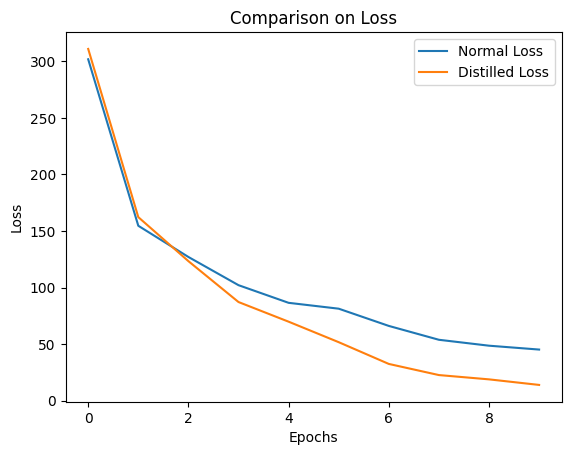

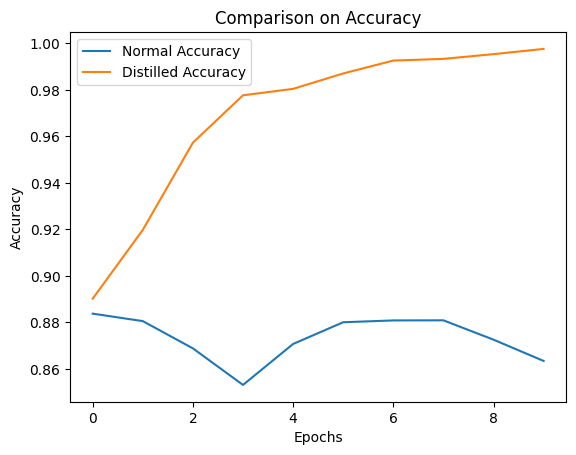

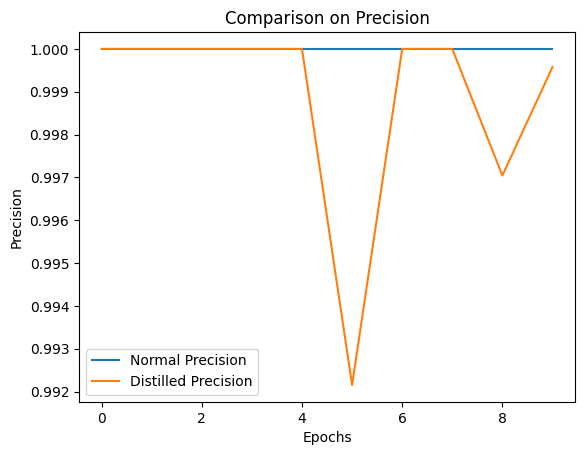

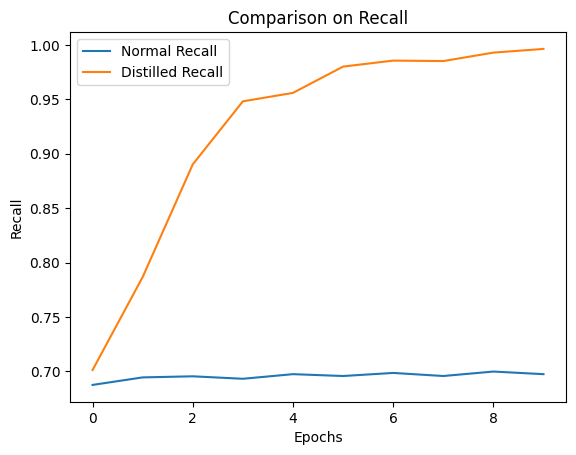

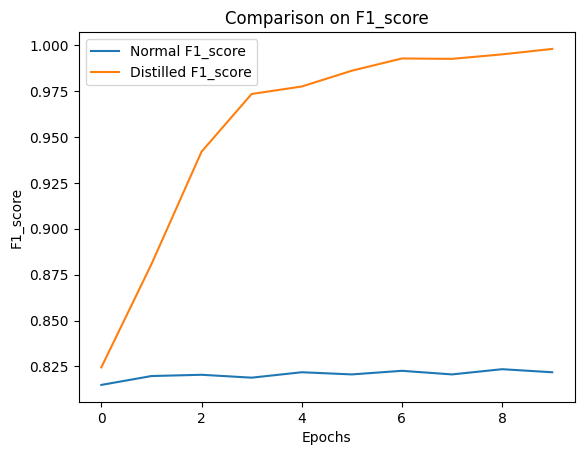

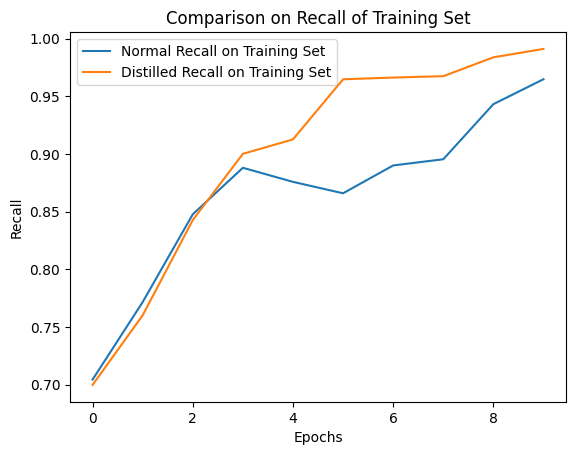

In [ ]:
plt.plot([i for i in range(epochs)], distilled_loss_list, label='Normal Loss')
plt.plot([i for i in range(epochs)], loss_list, label='Distilled Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison on Loss')
plt.legend()
plt.show()

plt.plot([i for i in range(epochs)], distilled_accuracy_list, label='Normal Accuracy')
plt.plot([i for i in range(epochs)], accuracy_list, label='Distilled Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Comparison on Accuracy')
plt.legend()
plt.show()

plt.plot([i for i in range(epochs)], distilled_precision_list, label='Normal Precision')
plt.plot([i for i in range(epochs)], precision_list, label='Distilled Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Comparison on Precision')
plt.legend()
plt.show()

plt.plot([i for i in range(epochs)], distilled_recall_list, label='Normal Recall')
plt.plot([i for i in range(epochs)], recall_list, label='Distilled Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Comparison on Recall')
plt.legend()
plt.show()

plt.plot([i for i in range(epochs)], distilled_f1_score_list, label='Normal F1_score')
plt.plot([i for i in range(epochs)], f1_score_list, label='Distilled F1_score')
plt.xlabel('Epochs')
plt.ylabel('F1_score')
plt.title('Comparison on F1_score')
plt.legend()
plt.show()

plt.plot([i for i in range(epochs)], distilled_recall_train_list, label='Normal Recall on Training Set')
plt.plot([i for i in range(epochs)], recall_train_list, label='Distilled Recall on Training Set')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Comparison on Recall of Training Set')
plt.legend()
plt.show()